In [1]:
#PHY 80 W23
#Lab 15: Muon Lifetime (09/02/23)
#Lab Partners: Ravi Kini, Sam Wu (Individual work of Ravi Kini)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import optimize
from scipy.stats import binom, poisson, norm
from scipy.integrate import quad

### 15.1

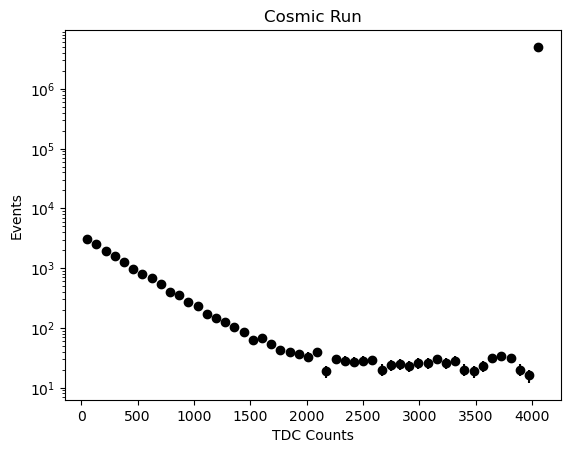

In [2]:
cosmics = np.load("../misc/phy80_cosmics.npy")

hx, edges = np.histogram(cosmics, 50)
cbins = (edges[1:] + edges[:-1])/2
plt.errorbar(cbins, hx, yerr=np.sqrt(hx), fmt="ko")
plt.xlabel("TDC Counts")
plt.ylabel("Events")
plt.yscale("log")
plt.title("Cosmic Run")
plt.show()

### 15.2

1 us mean: 174.864 +- 0.062 counts
2 us mean: 337.703 +- 0.066 counts
4 us mean: 667.031 +- 0.063 counts
8 us mean: 1321.524 +- 0.064 counts


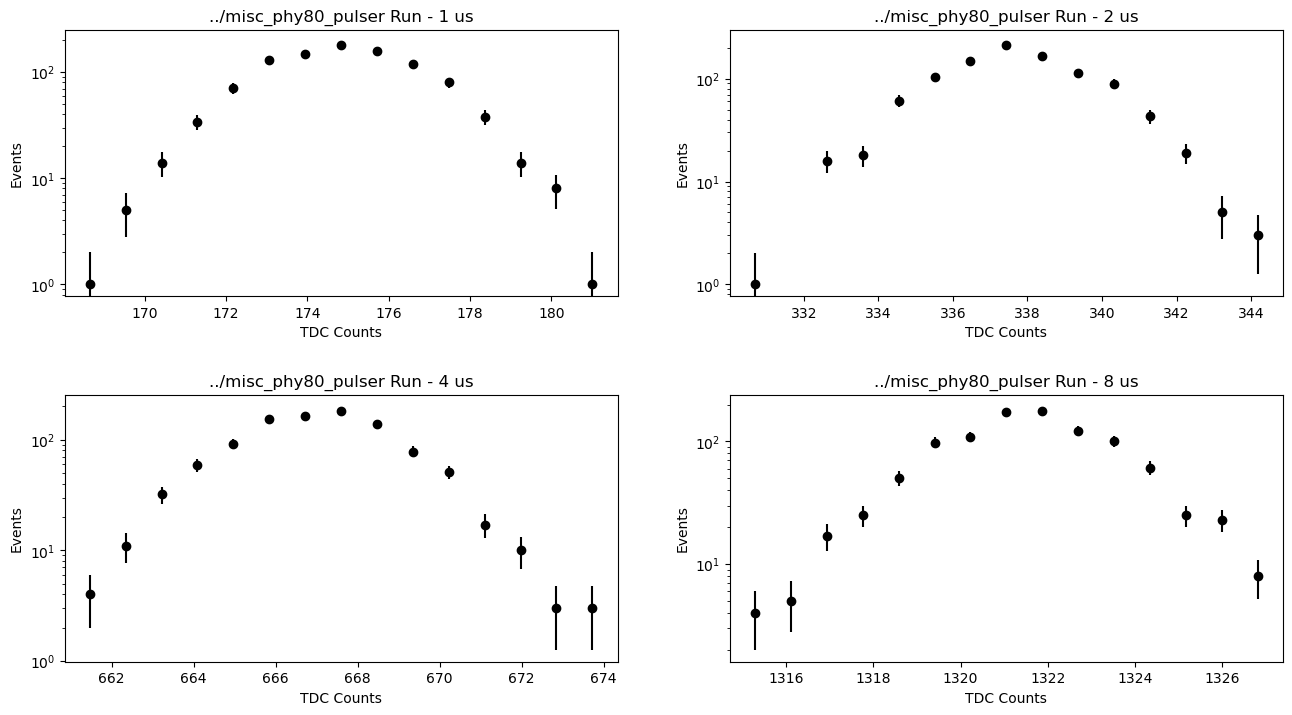

In [3]:
data1 = np.load("../misc/phy80_pulser_1.npy")
data2 = np.load("../misc/phy80_pulser_2.npy")
data3 = np.load("../misc/phy80_pulser_4.npy")
data4 = np.load("../misc/phy80_pulser_8.npy")

print("1 us mean:", round(np.mean(data1),3), "+-", round(np.sqrt(np.var(data1)/len(data1)),3), "counts")
print("2 us mean:", round(np.mean(data2),3), "+-", round(np.sqrt(np.var(data2)/len(data2)),3), "counts")
print("4 us mean:", round(np.mean(data3),3), "+-", round(np.sqrt(np.var(data3)/len(data3)),3), "counts")
print("8 us mean:", round(np.mean(data4),3), "+-", round(np.sqrt(np.var(data4)/len(data4)),3), "counts")

hx1, edges1 = np.histogram(data1, 15)
cbins1 = (edges1[1:] + edges1[:-1])/2
hx2, edges2 = np.histogram(data2, 15)
cbins2 = (edges2[1:] + edges2[:-1])/2
hx3, edges3 = np.histogram(data3, 15)
cbins3 = (edges3[1:] + edges3[:-1])/2
hx4, edges4 = np.histogram(data4, 15)
cbins4 = (edges4[1:] + edges4[:-1])/2
#calculate histograms and bin centers from data for each bin size

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout(pad=5.0)
axes[0][0].errorbar(cbins1, hx1, yerr=np.sqrt(hx1), fmt="ko")
axes[0][1].errorbar(cbins2, hx2, yerr=np.sqrt(hx2), fmt="ko")
axes[1][0].errorbar(cbins3, hx3, yerr=np.sqrt(hx3), fmt="ko")
axes[1][1].errorbar(cbins4, hx4, yerr=np.sqrt(hx4), fmt="ko")
#plot four horizontally stacked subplots with red (r) solid lines (-)

for i in range(2):
    for j in range(2):
        axes[i][j].set_xlabel("TDC Counts")
        axes[i][j].set_ylabel("Events")
        axes[i][j].set_yscale("log")
        axes[i][j].set_title("../misc_phy80_pulser Run - " + str(2**(j + 2*i)) + " us")
        #set x-label as "bins" and y-label as "counts" for each figure

### 15.3

best fit value of a:  163.871
uncertainty of a:  0.012
best fit value of b:  10.79
uncertainty of b:  0.05


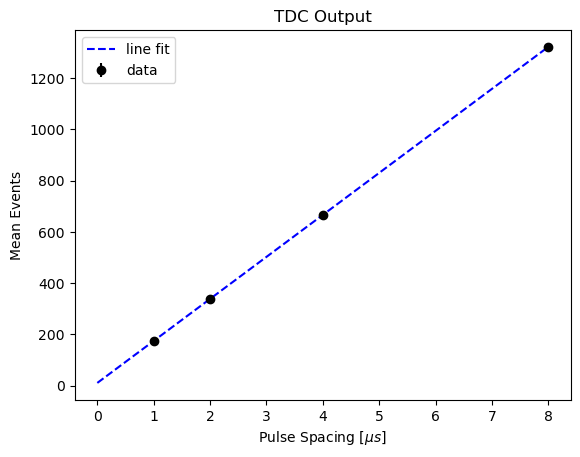

In [4]:
def line_func(x, a, b):
    return x * a + b

x_data = np.array([1., 2., 4., 8.])
y_data = np.array([np.mean(data1), np.mean(data2), np.mean(data3), np.mean(data4)])
y_unc = np.array([np.sqrt(np.var(data1)/len(data1)), np.sqrt(np.var(data2)/len(data2)), np.sqrt(np.var(data3)/len(data3)), np.sqrt(np.var(data4)/len(data4))])

guess_a = 1.0
guess_b = 0.0
par, cov = optimize.curve_fit(line_func, x_data, y_data, sigma=y_unc, p0=[guess_a, guess_b], absolute_sigma=True)

unc = np.sqrt(np.diag(cov))

fit_a = par[0]
unc_a = unc[0]
fit_b = par[1]
unc_b = unc[1]
print("best fit value of a: ", round(fit_a, 3))
print("uncertainty of a: ", round(unc_a, 3))
print("best fit value of b: ", round(fit_b, 2))
print("uncertainty of b: ", round(unc_b, 2))

plt.errorbar(x_data, y_data, yerr=y_unc, fmt="ko", label="data")
xf = np.linspace(0.0, 8.0, 100)
yf = fit_b + fit_a * xf
plt.plot(xf, yf, "b--", label="line fit")
plt.xlabel("Pulse Spacing [$\mu s$]")
plt.ylabel("Mean Events")
plt.legend()
plt.title("TDC Output")
plt.show()

### 15.4

In [5]:
chi_squared = np.sum(((line_func(x_data, fit_a, fit_b) - y_data)/y_unc)**2)
print("chi squared value: ", round(chi_squared, 5))
print("reduced chi squared value: ", round(chi_squared/(len(x_data) - 2), 5))
#the reduced chi squared value for a function that has been fitted to N data points is 1,
#although this could be a case of overfitting, the TDC is expected to be linear so this
#is likely a good fit, rather than overfitting, as a linear relationship is expected
#between the pulse spacing and the mean number of events

chi squared value:  327.15624
reduced chi squared value:  163.57812


### 15.5

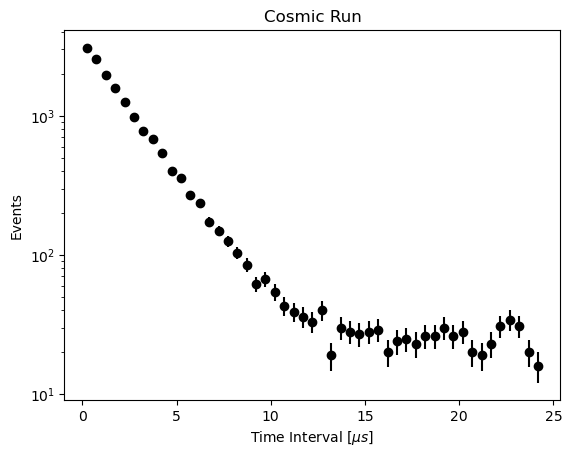

In [6]:
hx, edges = np.histogram((cosmics - fit_b)/fit_a, 50)
cbins = (edges[1:] + edges[:-1])/2
plt.errorbar(cbins[:-1], hx[:-1], yerr=np.sqrt(hx[:-1]), fmt="ko")
plt.xlabel("Time Interval [$\mu s$]")
plt.ylabel("Events")
plt.yscale("log")
plt.title("Cosmic Run")
plt.show()

### 15.6

best fit value of b:  22.663
uncertainty of b:  1.002
best fit value of N0:  3478.9
uncertainty of N0:  42.4
best fit value of tt:  2.17
uncertainty of tt:  0.02


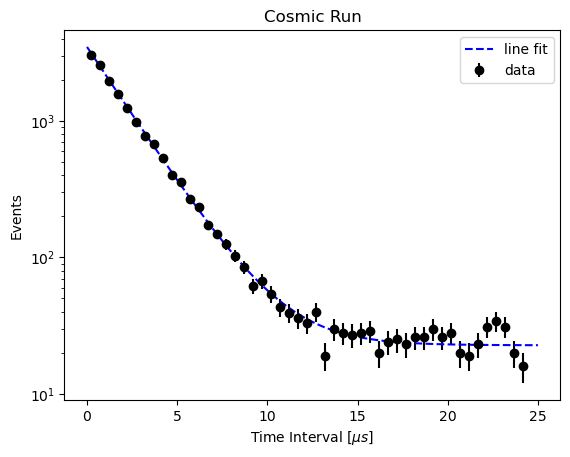

In [7]:
def exp_func(x, b, N0, tt):
    return b + N0 * np.exp(-1 * x/tt)

guess_b = 1.0
guess_N0 = 1.0
guess_tt = 1.0
par, cov = optimize.curve_fit(exp_func, cbins[:-1], hx[:-1], sigma=np.sqrt(hx[:-1]), p0=[guess_b, guess_N0, guess_tt], absolute_sigma=True)

unc = np.sqrt(np.diag(cov))

fit_b = par[0]
unc_b = unc[0]
fit_N0 = par[1]
unc_N0 = unc[1]
fit_tt = par[2]
unc_tt = unc[2]
print("best fit value of b: ", round(fit_b, 3))
print("uncertainty of b: ", round(unc_b, 3))
print("best fit value of N0: ", round(fit_N0, 1))
print("uncertainty of N0: ", round(unc_N0, 1))
print("best fit value of tt: ", round(fit_tt, 2))
print("uncertainty of tt: ", round(unc_tt, 2))

plt.errorbar(cbins[:-1], hx[:-1], yerr=np.sqrt(hx[:-1]), fmt="ko", label="data")
xf = np.linspace(0.0, 25.0, 100)
yf = exp_func(xf, fit_b, fit_N0, fit_tt)
plt.plot(xf, yf, "b--", label="line fit")
plt.xlabel("Time Interval [$\mu s$]")
plt.ylabel("Events")
plt.yscale("log")
plt.title("Cosmic Run")
plt.legend()
plt.show()

### 15.7

In [8]:
mu = fit_tt
mu_unc_stat = unc_tt
print("muon lifetime:", round(mu,2), "+-", round(mu_unc_stat,2), "us")

muon lifetime: 2.17 +- 0.02 us


### 15.8

In [9]:
chi_squared = np.sum(((exp_func(cbins[:-1], fit_b, fit_N0, fit_tt) - hx[:-1])/np.sqrt(hx[:-1]))**2)
print("chi squared value: ", round(chi_squared, 5))
print("reduced chi squared value: ", round(chi_squared/(len(cbins[:-1]) - 3), 5))
#the reduced chi squared value for a function that has been fitted to N data points is 1,
#the reduced chi squared value is around 1, which is reasonably close to a good fit

chi squared value:  40.82697
reduced chi squared value:  0.88754


### 15.9

In [10]:
mu_unc_sys = 0.05 * mu
mu_unc_tot = np.sqrt(mu_unc_stat**2 + mu_unc_sys**2)
print("our measured value lies within {0} sigmas of the known value".format(round((2.1969811 - mu)/(mu_unc_tot), 3)))
#our measured value is very close to the known value,
#and there is no statistical significance to differences between the two

our measured value lies within 0.242 sigmas of the known value


### 15.10

In [11]:
N = lambda t: fit_N0*np.exp(-1 * t/fit_tt)
print("muons detected per second:", round(quad(N, 0, fit_tt)[0]*1000/(5.787*24*60*60), 3))
#we expect 1/min/cm^2 * ((7.5 cm)^2 * pi + 7.5 cm * 12.5 cm) = 471 muons/minute = 8 muons/sec

muons detected per second: 9.545
